In [40]:
import argparse
import os.path as osp
from typing import Any, Dict, Optional
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.nn import (
    BatchNorm1d,
    Embedding,
    Linear,
    ModuleList,
    ReLU,
    Sequential,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch_geometric.transforms as T
from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, GPSConv, global_add_pool
from torch_geometric.nn.attention import PerformerAttention
from torch_geometric.utils import to_networkx

In [3]:

path = osp.join("C:\\Users\\zzh\\Desktop\\Oxford\\GeometricDeepLearning", '..', 'data', 'ZINC-PE')
transform = T.AddRandomWalkPE(walk_length=20, attr_name='pe')
train_dataset = ZINC(path, subset=True, split='train', pre_transform=transform)
val_dataset = ZINC(path, subset=True, split='val', pre_transform=transform)
test_dataset = ZINC(path, subset=True, split='test', pre_transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

parser = argparse.ArgumentParser()
parser.add_argument(
    '--attn_type', default='multihead',
    help="Global attention type such as 'multihead' or 'performer'.")
args = parser.parse_args()


Extracting C:\Users\zzh\Desktop\Oxford\data\ZINC-PE\molecules.zip
Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 1478.68it/s]
Done!
usage: ipykernel_launcher.py [-h] [--attn_type ATTN_TYPE]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\zzh\AppData\Roaming\jupyter\runtime\kernel-v3b24efe7af180141acaeb9bb14cdbe18d795c73fb.json


SystemExit: 2

C:\Users\zzh\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [28]:
class Args():
    attn_type = 'multihead'

args = Args()

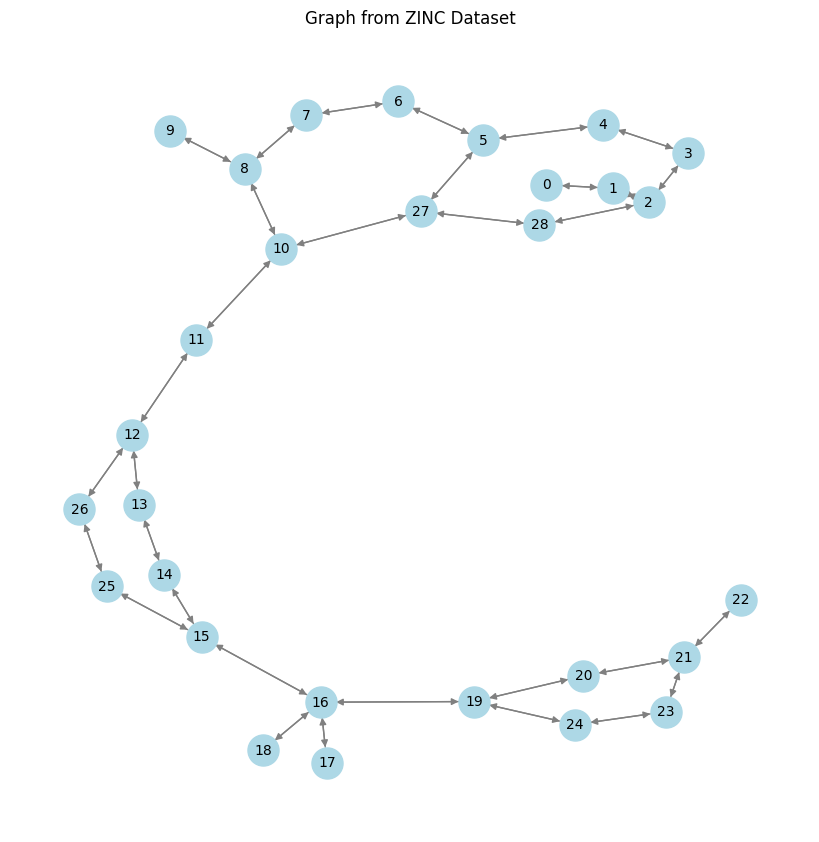

In [5]:

# Get a single graph from the dataset
data = train_dataset[0]  # Get the first graph

# Convert to NetworkX format
G = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'])

# Plot the graph
plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
plt.title("Graph from ZINC Dataset")
plt.show()

In [20]:
data

Data(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1], pe=[29, 20])

In [39]:



class GPS(torch.nn.Module):
    def __init__(self, enc_in, d_model: int, pe_dim: int, num_layers: int,
                 attn_type: str, attn_kwargs: Dict[str, Any]):
        super().__init__()

        channels = d_model
        self.node_emb = DataEmbedding_wo_temp(enc_in,d_model)
        self.pe_lin = Linear(20, pe_dim)
        self.pe_norm = BatchNorm1d(20)
        self.edge_emb = Embedding(4, channels)

        self.convs = ModuleList()
        for _ in range(num_layers):
            nn = Sequential(
                Linear(channels, channels),
                ReLU(),
                Linear(channels, channels),
            )
            conv = GPSConv(channels, GINEConv(nn), heads=4,
                           attn_type=attn_type, attn_kwargs=attn_kwargs)
            self.convs.append(conv)

        self.mlp = Sequential(
            Linear(channels, channels // 2),
            ReLU(),
            Linear(channels // 2, channels // 4),
            ReLU(),
            Linear(channels // 4, 1),
        )
        
        self.redraw_projection = RedrawProjection(
            self.convs,
            redraw_interval=1000 if attn_type == 'performer' else None)

    def forward(self, x, pe, edge_index, edge_attr, batch):
        x_pe = self.pe_norm(pe)
        x = torch.cat((self.node_emb(x.squeeze(-1)), self.pe_lin(x_pe)), 1)
        edge_attr = self.edge_emb(edge_attr)

        for conv in self.convs:
            x = conv(x, edge_index, batch, edge_attr=edge_attr)
        x = global_add_pool(x, batch)
        return self.mlp(x)


In [24]:


class RedrawProjection:
    def __init__(self, model: torch.nn.Module,
                 redraw_interval: Optional[int] = None):
        self.model = model
        self.redraw_interval = redraw_interval
        self.num_last_redraw = 0

    def redraw_projections(self):
        if not self.model.training or self.redraw_interval is None:
            return
        if self.num_last_redraw >= self.redraw_interval:
            fast_attentions = [
                module for module in self.model.modules()
                if isinstance(module, PerformerAttention)
            ]
            for fast_attention in fast_attentions:
                fast_attention.redraw_projection_matrix()
            self.num_last_redraw = 0
            return
        self.num_last_redraw += 1


In [29]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
attn_kwargs = {'dropout': 0.5}
model = GPS(channels=64, pe_dim=8, num_layers=10, attn_type=args.attn_type,
            attn_kwargs=attn_kwargs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20,
                              min_lr=0.00001)


In [31]:
model

GPS(
  (node_emb): Embedding(28, 56)
  (pe_lin): Linear(in_features=20, out_features=8, bias=True)
  (pe_norm): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (edge_emb): Embedding(4, 64)
  (convs): ModuleList(
    (0-9): 10 x GPSConv(64, conv=GINEConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )), heads=4, attn_type=multihead)
  )
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [48]:
train_dataset[23]

Data(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1], pe=[29, 20])

In [56]:
conv = model.convs[0]
conv

GPSConv(64, conv=GINEConv(nn=Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
)), heads=4, attn_type=multihead)

In [33]:
model.redraw_projection.redraw_projections()
out = model(data.x, data.pe, data.edge_index, data.edge_attr,
            data.batch)

In [49]:
data

Data(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1], pe=[29, 20])

In [55]:
edge_attr.shape

torch.Size([64, 64])

In [57]:
x_pe = model.pe_norm(data.pe)
x = torch.cat((model.node_emb(data.x.squeeze(-1)), model.pe_lin(x_pe)), 1)
edge_attr = model.edge_emb(data.edge_attr)

for conv in model.convs:
    x = conv(x, data.edge_index, data.batch, edge_attr=edge_attr)
x.shape
#x = global_add_pool(x, data.batch)

torch.Size([29, 64])

In [59]:
x

tensor([[ 0.8475, -0.6328, -0.0735,  ..., -0.3857, -0.1784,  0.4606],
        [-0.3255,  0.4303,  0.1852,  ...,  0.5157, -0.1556, -0.0678],
        [ 0.7754, -0.8561,  0.4793,  ..., -0.8338,  1.3971, -1.1867],
        ...,
        [ 0.4859, -0.1982, -0.4674,  ...,  0.0346, -0.8765,  0.7322],
        [ 0.3979, -0.7382,  0.5523,  ..., -0.6435,  1.1743, -0.9129],
        [ 0.6851, -0.7721,  0.9721,  ..., -1.0182,  0.8797, -0.5644]],
       grad_fn=<NativeBatchNormBackward0>)

In [36]:
x = global_add_pool(x, data.batch)
x.shape

torch.Size([1, 64])

In [38]:
model.mlp(x)

tensor([[0.0555]], grad_fn=<AddmmBackward0>)

In [30]:


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        model.redraw_projection.redraw_projections()
        out = model(data.x, data.pe, data.edge_index, data.edge_attr,
                    data.batch)
        loss = (out.squeeze() - data.y).abs().mean()
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    total_error = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.pe, data.edge_index, data.edge_attr,
                    data.batch)
        total_error += (out.squeeze() - data.y).abs().sum().item()
    return total_error / len(loader.dataset)


for epoch in range(1, 101):
    loss = train()
    val_mae = test(val_loader)
    test_mae = test(test_loader)
    scheduler.step(val_mae)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_mae:.4f}, '
          f'Test: {test_mae:.4f}')


Epoch: 01, Loss: 0.7083, Val: 0.7062, Test: 0.7113


KeyboardInterrupt: 